# Big Data Frameworks

## Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data loading

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType
import os

# Initialisation de la session Spark
spark = SparkSession.builder \
    .appName("Big Data Frameworks") \
    .config("spark.sql.files.maxPartitionBytes", "134217728") \
    .getOrCreate()

# Dossier des données
filepath = "drive/Shareddrives/BDF/Big_Data_Frameworks"
schema_file = os.path.join(filepath, "schema.csv")

# Lecture du schema.csv avec Spark
df_schema = spark.read.csv(schema_file, header=True, inferSchema=True)

# Extraction des schémas
dict_schemas = {}
for row in df_schema.collect():
    folder = row['file pattern'].split('/')[0]

    # Ajout au dictionnaire des schémas
    if folder not in dict_schemas:
        dict_schemas[folder] = []

    dict_schemas[folder].append((row["field number"], row["content"], row["format"]))

# Fonction pour charger un fichier avec Spark
def load_file_spark(file_path, schema):
    spark_schema = StructType([
        StructField(col[1], StringType(), True) for col in schema  # Conversion en StringType (peut être adapté)
    ])

    # Charger le fichier avec Spark (sans spécifier la compression)
    df_spark = spark.read.csv(file_path, schema=spark_schema, header=False)

    return df_spark


from functools import reduce

# Fonction pour traiter un dossier
def process_folder_spark(folder, schema):
    folder_path = os.path.join(filepath, "decompressed/" + folder)

    if not os.path.exists(folder_path):
        return None

    print(f"Processing {folder} ...")

    # Liste des fichiers CSV ou CSV.GZ
    all_files = sorted([f for f in os.listdir(folder_path) if f.endswith((".csv", ".csv.gz"))])

    # Charger et fusionner les fichiers avec Spark
    df_spark_list = [load_file_spark(os.path.join(folder_path, file), schema) for file in all_files[51:100]]

    if df_spark_list:
        # Utilisation de reduce pour effectuer l'union de plusieurs DataFrames
        return reduce(lambda df1, df2: df1.union(df2), df_spark_list)
    else:
        return None


# Traitement des dossiers avec Spark
df_spark_dict = {}
for folder, schema in dict_schemas.items():
    df_spark_dict[folder] = process_folder_spark(folder, schema)

# Afficher un exemple de DataFrame Spark
for folder, df in df_spark_dict.items():
    if df is not None:
        print(f"Exemple de données pour {folder}:")
        df.show(5)


Processing job_events ...
Processing task_events ...
Processing machine_events ...
Processing machine_attributes ...
Processing task_constraints ...
Processing task_usage ...
Exemple de données pour job_events:
+------------+------------+----------+----------+--------------------+----------------+--------------------+--------------------+
|        time|missing info|    job ID|event type|                user|scheduling class|            job name|    logical job name|
+------------+------------+----------+----------+--------------------+----------------+--------------------+--------------------+
|256171905035|  Unnamed: 1|6281347727|         4|0r3naaX+ybfsUIahb...|               1|OafiPIfvQnxASpEzq...|rSp0GRW2y6HCnfQZg...|
|256172659040|        NULL|6281359012|         1|F2+Gv53Pxd4KDRb/U...|               0|6cEyQ7YEIiUwugpf7...|2N2Ubknr/Ly7V95po...|
|256185883988|        NULL|6281360458|         0|YFckKi9Y5+O2JDbJm...|               3|Pwl9mSMuJ26sfQwi9...|GawJW3Q6jpFHQZVsI...|
|25618844

## Analyse des données

In [4]:
df_spark_dict

{'job_events': DataFrame[time: string, missing info: string, job ID: string, event type: string, user: string, scheduling class: string, job name: string, logical job name: string],
 'task_events': DataFrame[time: string, missing info: string, job ID: string, task index: string, machine ID: string, event type: string, user: string, scheduling class: string, priority: string, CPU request: string, memory request: string, disk space request: string, different machines restriction: string],
 'machine_events': None,
 'machine_attributes': None,
 'task_constraints': DataFrame[time: string, job ID: string, task index: string, comparison operator: string, attribute name: string, attribute value: string],
 'task_usage': DataFrame[start time: string, end time: string, job ID: string, task index: string, machine ID: string, CPU rate: string, canonical memory usage: string, assigned memory usage: string, unmapped page cache: string, total page cache: string, maximum memory usage: string, disk I/O 

In [5]:
df_jobs = df_spark_dict['job_events']
df_jobs

DataFrame[time: string, missing info: string, job ID: string, event type: string, user: string, scheduling class: string, job name: string, logical job name: string]

In [6]:
df_jobs.describe()

DataFrame[summary: string, time: string, missing info: string, job ID: string, event type: string, user: string, scheduling class: string, job name: string, logical job name: string]

In [36]:
df_jobs.head()

Row(time='0', missing info='Unnamed: 1', job ID='3418309', event type='0.1', user='70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', scheduling class='3', job name='IHgtoxEBuUTHNbUeVs4hzptMY4n8rZKLbZg+Jh5fNG4=', logical job name='wAmgn2H74cdoMuSFwJF3NaUEaudVBTZ0/HaNZBwIpEQ=')

In [8]:
df_jobs.tail(1)

[Row(time='251158892444', missing info=None, job ID='6280825066', event type='4', user='mbrS6V2tRbksMPO0y8EI9B9XT2ASaPRTNndslCGN/2A=', scheduling class='1', job name='VsxVaQ0Wm1ok7y+KSxfUV3Oayk9iko5KhexmBf8/Qr0=', logical job name='jyZZdXJ39S3TzTcdmtfnhVqbPaeqRoynOOTNE36Hv9k=')]

In [9]:
df_jobs.dtypes

[('time', 'string'),
 ('missing info', 'string'),
 ('job ID', 'string'),
 ('event type', 'string'),
 ('user', 'string'),
 ('scheduling class', 'string'),
 ('job name', 'string'),
 ('logical job name', 'string')]

In [10]:
df_jobs.columns

['time',
 'missing info',
 'job ID',
 'event type',
 'user',
 'scheduling class',
 'job name',
 'logical job name']

In [ ]:
# df_jobs.isnull().sum()

In [7]:
for col in df_jobs.columns:
    if col.upper() != 'USER':
        print(f'{col.upper()} :')
        df_jobs.select(col).distinct().show()


TIME :
+------------+
|        time|
+------------+
|256211734360|
|256489163860|
|256545145662|
|256760937581|
|257164482843|
|258228889355|
|258550089602|
|258618412963|
|258756847064|
|258926619027|
|258982001783|
|259304210025|
|260031463418|
|260552099819|
|260687952476|
|256272408996|
|256425644868|
|256547119996|
|256638166486|
|256863426621|
+------------+
only showing top 20 rows

MISSING INFO :
+------------+
|missing info|
+------------+
|  Unnamed: 1|
|         1.0|
|        NULL|
+------------+

JOB ID :
+----------+
|    job ID|
+----------+
|6281361317|
|6281394571|
|6281403820|
|6281409542|
|6281421761|
|6281581514|
|6281686132|
|6281850570|
|6281870236|
|6282004219|
|6282090570|
|6282133250|
|6281359417|
|6281394628|
|6281485365|
|6281511454|
|6281567485|
|6281776706|
|6280588084|
|6281989630|
+----------+
only showing top 20 rows

EVENT TYPE :
+----------+
|event type|
+----------+
|         3|
|         0|
|         5|
|         1|
|         4|
|         6|
|        

## Pre-processing

### Type issues

In [8]:
def check_type(data, columns):
    for col in columns:

        # Affichage du type global de la colonne
        print(f"Type global de la variable '{col}': {data.schema[col].dataType}")

        # Trouver les types uniques dans la colonne
        unique_types_df = data.select(col).distinct()  # Sélectionner les valeurs distinctes
        unique_types = unique_types_df.rdd.map(lambda row: type(row[0])).distinct().collect()

        # Afficher les types uniques dans la colonne
        print(f"Liste des types uniques dans la variable '{col}': {unique_types}")
        print()

from pyspark.sql.types import StringType, IntegerType, FloatType

def display_type(data, columns, _type):
    # Mapping des types python vers les types PySpark
    type_mapping = {
        'str': StringType(),  # Utilisation de StringType() pour str
        'int': IntegerType(),
        'float': FloatType()
    }

    for col in columns:

        # Sélectionner la colonne et filtrer les éléments du bon type
        filtered_values_df = data.select(col).filter(F.col(col).cast(type_mapping[_type]).isNotNull()).limit(1000)

        # Collecter les résultats filtrés
        filtered_values = [row[col] for row in filtered_values_df.collect()]

        # Affichage des résultats
        print(f"Liste des éléments de type {_type} dans la colonne '{col}':", filtered_values)
        print("Nombre d'éléments de type", _type, ":", len(filtered_values))
        print()



---

## 1. Identification des travaux et tâches (jobs et tasks dans la nomenclature de Google) les plus prenants en CPU, en valeurs maximales et en moyenne pendant la durée de la trace. Ces travaux seront appelés désormais jobs dominants

In [9]:
df_task_usage = df_spark_dict["task_usage"]
df_task_usage

DataFrame[start time: string, end time: string, job ID: string, task index: string, machine ID: string, CPU rate: string, canonical memory usage: string, assigned memory usage: string, unmapped page cache: string, total page cache: string, maximum memory usage: string, disk I/O time: string, local disk space usage: string, maximum CPU rate: string, maximum disk IO time: string, cycles per instruction: string, memory accesses per instruction: string, sample portion: string, aggregation type: string, sampled CPU usage: string]

In [10]:
df_task_usage.columns

['start time',
 'end time',
 'job ID',
 'task index',
 'machine ID',
 'CPU rate',
 'canonical memory usage',
 'assigned memory usage',
 'unmapped page cache',
 'total page cache',
 'maximum memory usage',
 'disk I/O time',
 'local disk space usage',
 'maximum CPU rate',
 'maximum disk IO time',
 'cycles per instruction',
 'memory accesses per instruction',
 'sample portion',
 'aggregation type',
 'sampled CPU usage']

In [11]:
print(df_task_usage['maximum CPU rate'].dtypes)

Column<'maximum CPU rate[dtypes]'>


Les données sont toutes des float, cela ne nécessite aucun traitement.

In [ ]:
# df_cpu.isnull().sum()

Aucune valeur manquante pour ces deux champs, ce qui va grandement faciliter l'analyse.

In [14]:
from pyspark.sql import functions as F

df_cpu = df_task_usage.groupBy("job ID", "task index").agg(
    F.max("maximum CPU rate").alias("max_CPU")
)

df_cpu_sorted = df_cpu.orderBy(F.desc("max_CPU"))
df_cpu_sorted.show(5)

+----------+----------+---------+
|    job ID|task index|  max_CPU|
+----------+----------+---------+
|6282133822|       527|    9.984|
|4672894572|        16|    9.969|
|6282102712|       731|    9.953|
|6292104192|      2490|    9.953|
|5567180387|       174|9.918e-05|
+----------+----------+---------+
only showing top 5 rows



In [15]:
import shutil

# Définir le dossier de destination
output_folder = "/content/drive/MyDrive/Big_Data_Frameworks/decompressed/cpu_max"
output_file = os.path.join(output_folder, "cpu_max_51_100.csv")

# S'assurer que le dossier existe
os.makedirs(output_folder, exist_ok=True)

df_cpu_limited = df_cpu_sorted.limit(100)

# Écriture dans un dossier temporaire
temp_folder = os.path.join(output_folder, "temp_output")
df_cpu_limited.coalesce(1).write.csv(temp_folder, header=True, mode="overwrite")

# Trouver le fichier généré par Spark (part-xxxxx.csv)
csv_file = [f for f in os.listdir(temp_folder) if f.startswith("part-") and f.endswith(".csv")][0]

# Renommer et déplacer le fichier dans le dossier `cpu_max`
shutil.move(os.path.join(temp_folder, csv_file), output_file)

# Supprimer le dossier temporaire
shutil.rmtree(temp_folder)

print(f"Fichier enregistré sous : {output_file}")


Fichier enregistré sous : /content/drive/MyDrive/Big_Data_Frameworks/decompressed/cpu_max/cpu_max_51_100.csv


In [18]:
mean_trace = df_task_usage.groupBy("job ID").agg(
    F.mean("maximum CPU rate").alias("mean_max_cpu_rate"),
    F.mean("CPU rate").alias("mean_cpu_rate")
)

mean_trace.show()

+----------+--------------------+--------------------+
|    job ID|   mean_max_cpu_rate|       mean_cpu_rate|
+----------+--------------------+--------------------+
|3350267310|                 0.0|1.351592537313433...|
|3760070065|0.001935938888888...|1.395246031746032...|
|3800750574|  0.0885512332112332|0.003533877899877899|
|4294109845| 0.06736109890109888|0.002525224664224664|
|5007846463| 0.00752338457154488|0.002398579910441...|
|5556388735|0.025725005494505498|0.001931815506715507|
|5943138316|0.037737793650793654|5.852307692307692E-4|
|6117133147|0.004527296836982...|0.002027009732360098|
|6127571338| 0.05944108669108668|0.003004362637362...|
|6127575571| 0.08319623931623929|0.002314229059829061|
|6127578300| 0.09979410989010985|0.002935308302808...|
|6127628778|0.005145086813186812|5.315594627594627E-4|
|6129259703|0.002577968986568988|4.641245421245421E-5|
|6137696559|0.005407885592185592|8.309639560439558E-4|
|6210418761|0.001401686935286...|2.992568376068375...|
|626569907

In [16]:
df_cpu = df_task_usage.groupBy("job ID", "task index").agg(
    F.mean("maximum CPU rate").alias("mean_CPU")
)

df_cpu_sorted = df_cpu.orderBy(F.desc("mean_CPU"))
df_cpu_sorted.show(5)

+----------+----------+------------------+
|    job ID|task index|          mean_CPU|
+----------+----------+------------------+
|6000622471|        16| 3.161567885615249|
|6283829535|       155|        3.04325727|
|6289505850|       280|       3.025255375|
|6289091797|        98|2.4784088888888887|
|6287387542|       118|       2.028004625|
+----------+----------+------------------+
only showing top 5 rows



In [17]:
import os
import shutil

# Définir le dossier de destination
output_folder = "/content/drive/MyDrive/Big_Data_Frameworks/decompressed/cpu_mean"
output_file = os.path.join(output_folder, "cpu_mean_51_100.csv")

# S'assurer que le dossier existe
os.makedirs(output_folder, exist_ok=True)
df_cpu_limited = df_cpu_sorted.limit(100)


# Écriture dans un dossier temporaire
temp_folder = os.path.join(output_folder, "temp_output")
df_cpu_limited.coalesce(1).write.csv(temp_folder, header=True, mode="overwrite")

# Trouver le fichier généré par Spark (part-xxxxx.csv)
csv_file = [f for f in os.listdir(temp_folder) if f.startswith("part-") and f.endswith(".csv")][0]

# Renommer et déplacer le fichier dans le dossier `cpu_max`
shutil.move(os.path.join(temp_folder, csv_file), output_file)

# Supprimer le dossier temporaire
shutil.rmtree(temp_folder)

print(f"Fichier enregistré sous : {output_file}")


Fichier enregistré sous : /content/drive/MyDrive/Big_Data_Frameworks/decompressed/cpu_mean/cpu_mean_51_100.csv


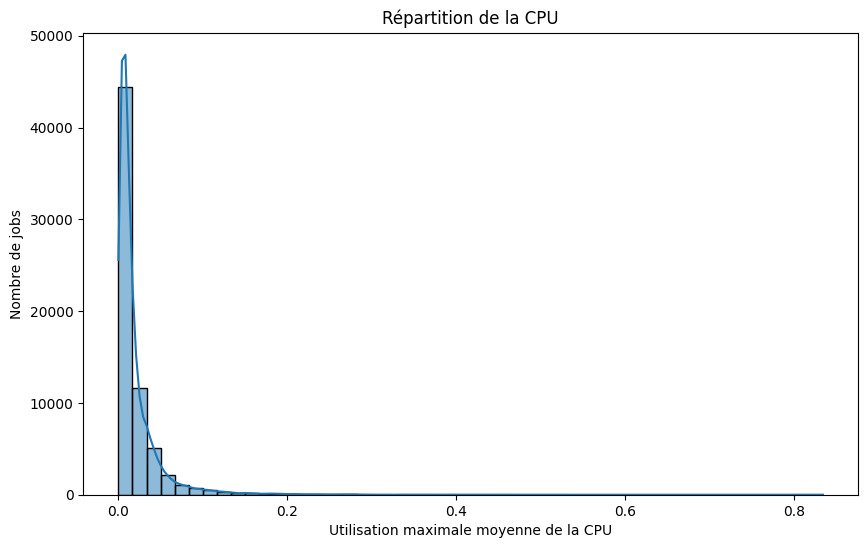

In [19]:
mean_trace_pd = mean_trace.toPandas()

# Créer un histogramme de la répartition de la CPU
plt.figure(figsize=(10, 6))
sns.histplot(mean_trace_pd["mean_max_cpu_rate"], bins=50, kde=True)
plt.title('Répartition de la CPU')
plt.xlabel('Utilisation maximale moyenne de la CPU')
plt.ylabel('Nombre de jobs')
plt.show()

---

## 2. Identification des jobs et tasks les plus prenants en mémoire vive, en valeurs maximales et en moyenne pendant la durée de la trace

Nous allons utiliser Maximum memory usage des fichiers issus du dossier task_usage, mais pour cela nous devons au préalable vérifier s'il contient des valeurs manquantes et vérifier les types. 

In [20]:
# Colonnes à vérifier
columns = ['maximum memory usage']

check_type(df_task_usage, columns)

Type global de la variable 'maximum memory usage': StringType()
Liste des types uniques dans la variable 'maximum memory usage': [<class 'str'>]



En effet, cette variable a plusieurs types, il faut donc corriger cela. Mais on va tout de même vérifier si c'est des erreurs de saisie ou des erreurs de typage.

In [21]:
display_type(df_task_usage, columns, 'str')

Liste des éléments de type str dans la colonne 'maximum memory usage': ['0.06738.1', '0.06787', '0.0', '7.153e-05', '0.0002966', '0.0007067', '0.003693', '0.0001974', '0.0004578', '0.0004988', '0.001413', '0.0', '0.001268', '0.001337', '0.001328', '0.01828', '0.01276', '0.001719', '0.003532', '0.0', '0.0', '0.0', '0.00473', '0.0', '0.0', '0.005318', '0.005943', '0.007523', '0.006554', '0.005844', '0.0065', '0.005539', '0.0', '0.0', '0.0', '0.005363', '0.005104', '0.005219', '0.005089', '0.001892', '0.01021', '0.0', '0.003284', '0.00589', '0.0', '0.003597', '0.005478', '0.003784', '0.003174', '0.004997', '0.006012', '0.003418', '0.003521', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.008423', '0.004906', '0.007919', '0.01718', '0.03717', '0.0387', '0.000351', '0.0006266', '0.001095', '0.0003195', '0.001652', '0.0', '0.001427', '0.001608', '0.0', '0.001123', '0.001076', '0.01106', '0.0', '0.001392', '0.0', '0.0', '0.001553', '0.001554', '0.01048', '0.009369', '0.0', '0.0', '0.0', '0.0', 

In [23]:
# Colonnes à vérifier
columns = ['maximum memory usage']

check_type(df_task_usage, columns)

Type global de la variable 'maximum memory usage': StringType()
Liste des types uniques dans la variable 'maximum memory usage': [<class 'str'>]



Maintenant qu'il ne reste qu'un seul type, nous allons pouvoir procéder au traitement.

In [24]:
df_memory = df_task_usage.groupBy("job ID", "task index").agg(
    F.max("maximum memory usage").alias("max"),
    F.mean("maximum memory usage").alias("mean")
)

# Affichage des jobs avec la plus forte utilisation mémoire maximale
print("Jobs avec la plus forte utilisation mémoire maximale :\n")
df_memory_sorted_max = df_memory.orderBy("max", ascending=False)
df_memory_sorted_max.show(10)

# Calcul de la moyenne du maximum de consommation mémoire par job
mean_memory_trace = df_task_usage.groupBy("job ID").agg(F.mean("maximum memory usage").alias("mean_usage"))

# Affichage des jobs avec la plus forte utilisation mémoire moyenne
print("\nJobs avec la plus forte utilisation mémoire moyenne :\n")
df_memory_sorted_mean = df_memory.orderBy("mean", ascending=False)
df_memory_sorted_mean.show(10)

Jobs avec la plus forte utilisation mémoire maximale :

+----------+----------+---------+--------------------+
|    job ID|task index|      max|                mean|
+----------+----------+---------+--------------------+
|6117800987|         2|9.918e-05|0.001356406618556...|
|5664371117|       354|9.918e-05|1.173775995174909...|
|5664371117|       711|9.918e-05|1.202283180428134...|
|5664371117|       378|9.918e-05|1.268199148418492E-4|
|5664371117|       464|9.918e-05|1.427248293299621...|
|5664371117|        66|9.918e-05|1.173381508515814...|
|6277853776|       357|9.918e-05|1.748519817767654...|
|5664371117|       449|9.918e-05|1.221898975672215E-4|
|5664371117|       567|9.918e-05|1.309198694516971...|
|5285926325|         0|9.918e-05| 2.76343728029563E-4|
+----------+----------+---------+--------------------+
only showing top 10 rows


Jobs avec la plus forte utilisation mémoire moyenne :

+----------+----------+------+-------------------+
|    job ID|task index|   max|           

In [26]:
print(df_memory_sorted_max_pd["max"].describe())


count     2221441
unique       5319
top           0.0
freq        66809
Name: max, dtype: object


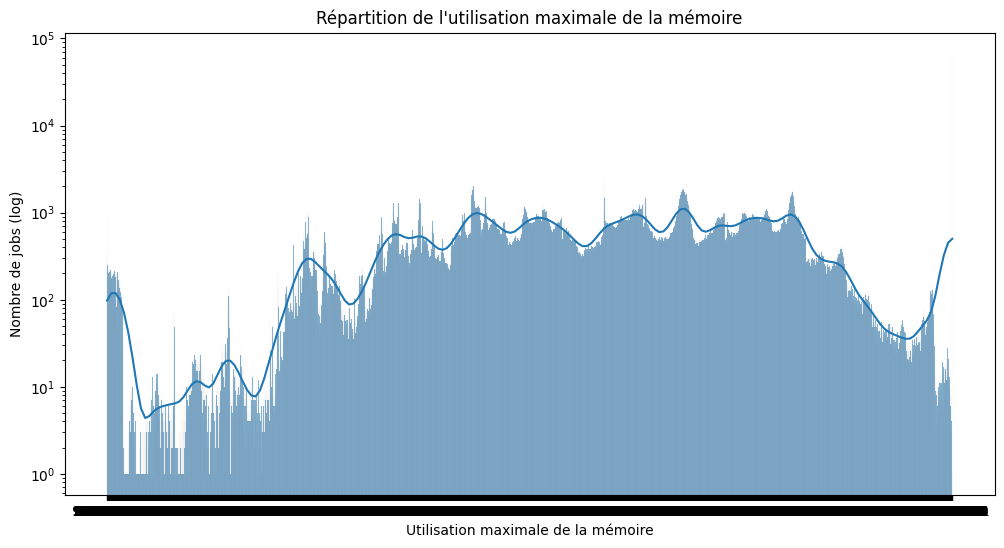

In [27]:
df_memory_sorted_max_pd = df_memory_sorted_max.toPandas()

plt.figure(figsize=(12, 6))
sns.histplot(df_memory_sorted_max_pd["max"], bins=50, kde=True)
plt.yscale("log")  # Met l'axe Y en échelle logarithmique
plt.title("Répartition de l'utilisation maximale de la mémoire")
plt.xlabel("Utilisation maximale de la mémoire")
plt.ylabel("Nombre de jobs (log)")
plt.show()
